In [39]:
! pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [40]:
import numpy as np
import pandas as pd

from matplotlib.colors import rgb2hex
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt

from collections import defaultdict, Counter

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import RidgeClassifier, SGDClassifier, Lasso, RidgeCV
from xgboost import XGBClassifier

import shap

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Playing with data

In [42]:
def parseFile( file_name ):
	f = open(file_name)
	featureArray = []
	lines = f.readlines()
	for line in lines:
		feature_length = len(line.split(" "))

		raw_feature = line.split(" ")

		feature = []

		for index in range(feature_length):
			try:
				feature.append( float( raw_feature[index] ))
			except:
				continue
		
		featureArray.append( feature )

	return np.asarray( featureArray )

In [43]:
folder = 'drive/MyDrive/human-activity-data-toronto-ucu/UCI-HAR-Dataset/'

#Parsing Full training dataset
XFull = parseFile(folder + 'train/X_train.txt')
YFull = parseFile(folder + 'train/y_train.txt')

#Parsing Full testing dataset
XFullTest = parseFile(folder + 'test/X_test.txt')
YFullTest = parseFile(folder + 'test/y_test.txt')

In [44]:
XFull

array([[ 0.28858451, -0.02029417, -0.13290514, ..., -0.84124676,
         0.17994061, -0.05862692],
       [ 0.27841883, -0.01641057, -0.12352019, ..., -0.8447876 ,
         0.18028889, -0.05431672],
       [ 0.27965306, -0.01946716, -0.11346169, ..., -0.84893347,
         0.18063731, -0.04911782],
       ...,
       [ 0.27338737, -0.01701062, -0.04502183, ..., -0.77913261,
         0.24914484,  0.04081119],
       [ 0.28965416, -0.01884304, -0.15828059, ..., -0.78518142,
         0.24643223,  0.02533948],
       [ 0.35150347, -0.01242312, -0.20386717, ..., -0.78326693,
         0.24680852,  0.03669484]])

In [45]:
len(XFull), len(XFull[1])

(7352, 561)

### Features & labels names

In [46]:
f = open(folder + 'features.txt')
featureArray = []
features = []
lines = f.readlines()

for line in lines:
  raw_feature = line.split(" ")
  features.append(raw_feature[1][:-1])

features

['tBodyAcc-mean()-X',
 'tBodyAcc-mean()-Y',
 'tBodyAcc-mean()-Z',
 'tBodyAcc-std()-X',
 'tBodyAcc-std()-Y',
 'tBodyAcc-std()-Z',
 'tBodyAcc-mad()-X',
 'tBodyAcc-mad()-Y',
 'tBodyAcc-mad()-Z',
 'tBodyAcc-max()-X',
 'tBodyAcc-max()-Y',
 'tBodyAcc-max()-Z',
 'tBodyAcc-min()-X',
 'tBodyAcc-min()-Y',
 'tBodyAcc-min()-Z',
 'tBodyAcc-sma()',
 'tBodyAcc-energy()-X',
 'tBodyAcc-energy()-Y',
 'tBodyAcc-energy()-Z',
 'tBodyAcc-iqr()-X',
 'tBodyAcc-iqr()-Y',
 'tBodyAcc-iqr()-Z',
 'tBodyAcc-entropy()-X',
 'tBodyAcc-entropy()-Y',
 'tBodyAcc-entropy()-Z',
 'tBodyAcc-arCoeff()-X,1',
 'tBodyAcc-arCoeff()-X,2',
 'tBodyAcc-arCoeff()-X,3',
 'tBodyAcc-arCoeff()-X,4',
 'tBodyAcc-arCoeff()-Y,1',
 'tBodyAcc-arCoeff()-Y,2',
 'tBodyAcc-arCoeff()-Y,3',
 'tBodyAcc-arCoeff()-Y,4',
 'tBodyAcc-arCoeff()-Z,1',
 'tBodyAcc-arCoeff()-Z,2',
 'tBodyAcc-arCoeff()-Z,3',
 'tBodyAcc-arCoeff()-Z,4',
 'tBodyAcc-correlation()-X,Y',
 'tBodyAcc-correlation()-X,Z',
 'tBodyAcc-correlation()-Y,Z',
 'tGravityAcc-mean()-X',
 'tGravityA

In [47]:
f = open(folder + 'activity_labels.txt')
featureArray = []
activity_labels = []
lines = f.readlines()

for line in lines:
  raw_feature = line.split(" ")
  activity_labels.append(raw_feature[1][:-1])

activity_labels

['WALKING',
 'WALKING_UPSTAIRS',
 'WALKING_DOWNSTAIRS',
 'SITTING',
 'STANDING',
 'LAYING']

### Activity Exploration

In [48]:
train_df = pd.DataFrame(XFull, columns=features)
train_df['label'] = YFull
train_df['activity'] = [activity_labels[int(x)-1] for x in train_df['label']]
train_df

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",label,activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,5.0,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,5.0,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,5.0,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,5.0,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,5.0,STANDING
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,0.299665,-0.057193,-0.181233,-0.195387,0.039905,0.077078,-0.282301,0.043616,0.060410,0.210795,...,-0.880324,-0.190437,0.829718,0.206972,-0.425619,-0.791883,0.238604,0.049819,2.0,WALKING_UPSTAIRS
7348,0.273853,-0.007749,-0.147468,-0.235309,0.004816,0.059280,-0.322552,-0.029456,0.080585,0.117440,...,-0.680744,0.064907,0.875679,-0.879033,0.400219,-0.771840,0.252676,0.050053,2.0,WALKING_UPSTAIRS
7349,0.273387,-0.017011,-0.045022,-0.218218,-0.103822,0.274533,-0.304515,-0.098913,0.332584,0.043999,...,-0.304029,0.052806,-0.266724,0.864404,0.701169,-0.779133,0.249145,0.040811,2.0,WALKING_UPSTAIRS
7350,0.289654,-0.018843,-0.158281,-0.219139,-0.111412,0.268893,-0.310487,-0.068200,0.319473,0.101702,...,-0.344314,-0.101360,0.700740,0.936674,-0.589479,-0.785181,0.246432,0.025339,2.0,WALKING_UPSTAIRS


In [49]:
# Group and count main names of columns
pd.DataFrame.from_dict(Counter([col.split('-')[0].split('(')[0] for col in train_df.columns]), orient='index').rename(columns={0:'count'}).sort_values('count', ascending=False)

,count
fBodyAcc,79
fBodyGyro,79
fBodyAccJerk,79
tGravityAcc,40
tBodyAcc,40
tBodyGyroJerk,40
tBodyGyro,40
tBodyAccJerk,40
tBodyAccMag,13
tGravityAccMag,13


From the plot below we can see that the classes are highly separable which will definitely help out model to distingusih classes with high accuracy.

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


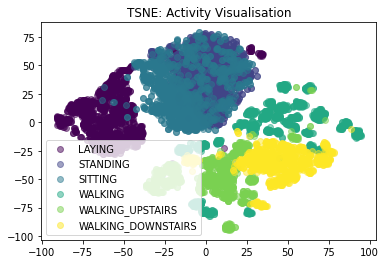

In [50]:
# Create datasets
tsne_data = train_df.copy()
subject_data = tsne_data.pop('activity')

# Scale data
scl = StandardScaler()
tsne_data = scl.fit_transform(tsne_data)

# Reduce dimensions (speed up)
pca = PCA(n_components=0.9, random_state=3)
tsne_data = pca.fit_transform(tsne_data)

# Transform data
tsne = TSNE(random_state=3)
tsne_transformed = tsne.fit_transform(tsne_data)


# Create subplots
plt.plot(figsize=(15,10))

### Plot Activities
# Get colors
n = len(activity_labels)
colormap = get_cmap('viridis')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

# Plot each activity
label_counts = subject_data.value_counts()
for i, group in enumerate(label_counts.index):
    # Mask to separate sets
    mask = (subject_data==group).values
    plt.scatter(x=tsne_transformed[mask][:,0], y=tsne_transformed[mask][:,1], c=colors[i], alpha=0.5, label=group)
plt.title('TSNE: Activity Visualisation')
plt.legend()

plt.show()

## Human activity classification

Compared different classifiers performance on this problem.

In [51]:
names = [
    "Lasso",
    "Ridge",
    "XGBoost",
    "Stochastic Gradient Descent",
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Decision Tree",
    "Random Forest",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    Lasso(alpha=0.1),
    RidgeClassifier(),
    XGBClassifier(),
    SGDClassifier(),
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

In [52]:
for name, clf in zip(names, classifiers):
  clf.fit(XFull, YFull.flatten())
  score = clf.score(XFullTest, YFullTest)
  print(name)
  print(score)

Lasso
0.8300559129906735
Ridge
0.9569053274516457
XGBoost
0.9395995928062436
Stochastic Gradient Descent
0.9524940617577197
Nearest Neighbors
0.8907363420427553
Linear SVM
0.9552086868001357
RBF SVM
0.18221920597217509
Decision Tree
0.839497794367153
Random Forest
0.7305734645402104
AdaBoost
0.5310485239226331
Naive Bayes
0.7702748557855447


Variables are collinear


QDA
0.8008143875127248


## Explanation for models with the best performance

Features importance for Ridge Classifier

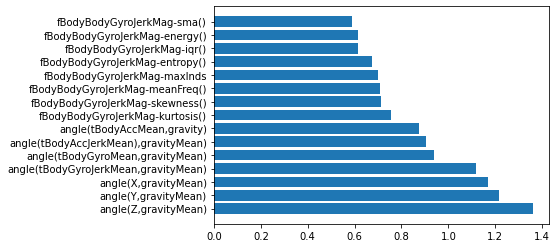

In [53]:
clf = RidgeClassifier()
clf.fit(XFull, YFull.flatten())

imp = abs(clf.coef_[0])
imp, names = zip(*sorted(list(zip(imp, features))))

top = 15
plt.barh(range(top), imp[::-1][0:top], align='center')
plt.yticks(range(top), features[::-1][0:top])
plt.show()

Features importance for Linear SVM

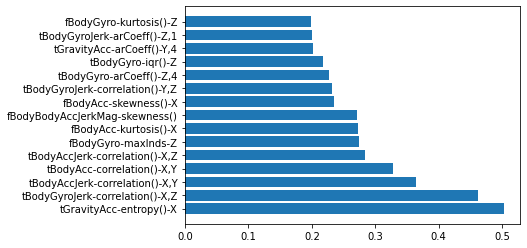

In [54]:
svm = SVC(kernel="linear", C=0.025)
svm.fit(XFull, YFull.flatten())

imp = abs(svm.coef_[0])
imp, names = zip(*sorted(list(zip(imp, features))))

top = 15
plt.barh(range(top), imp[::-1][0:top], align='center')
plt.yticks(range(top), names[::-1][0:top])
plt.show()

Shapley Values for XGBoost

In [55]:
model = XGBClassifier()
model.fit(XFull, YFull.flatten())

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(XFull)
# View shap values
shap_values

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([[ 0.        , -0.00646696, -0.00235362, ...,  0.00074533,
         -0.03338762,  0.        ],
        [ 0.        , -0.00646696, -0.00235362, ...,  0.00074533,
         -0.05257973,  0.        ],
        [ 0.        , -0.00646696, -0.00235362, ...,  0.00074533,
         -0.05257973,  0.        ],
        ...,
        [ 0.        , -0.00149787, -0.00053162, ...,  0.00200744,
         -0.04226222,  0.        ],
        [ 0.        , -0.00149787, -0.00053162, ...,  0.00200744,
         -0.05101839,  0.        ],
        [ 0.        , -0.00149787, -0.00053162, ...,  0.00200744,
         -0.04226222,  0.        ]], dtype=float32),
 array([[-0.00158349,  0.        , -0.01362788, ...,  0.00111092,
          0.        , -0.010

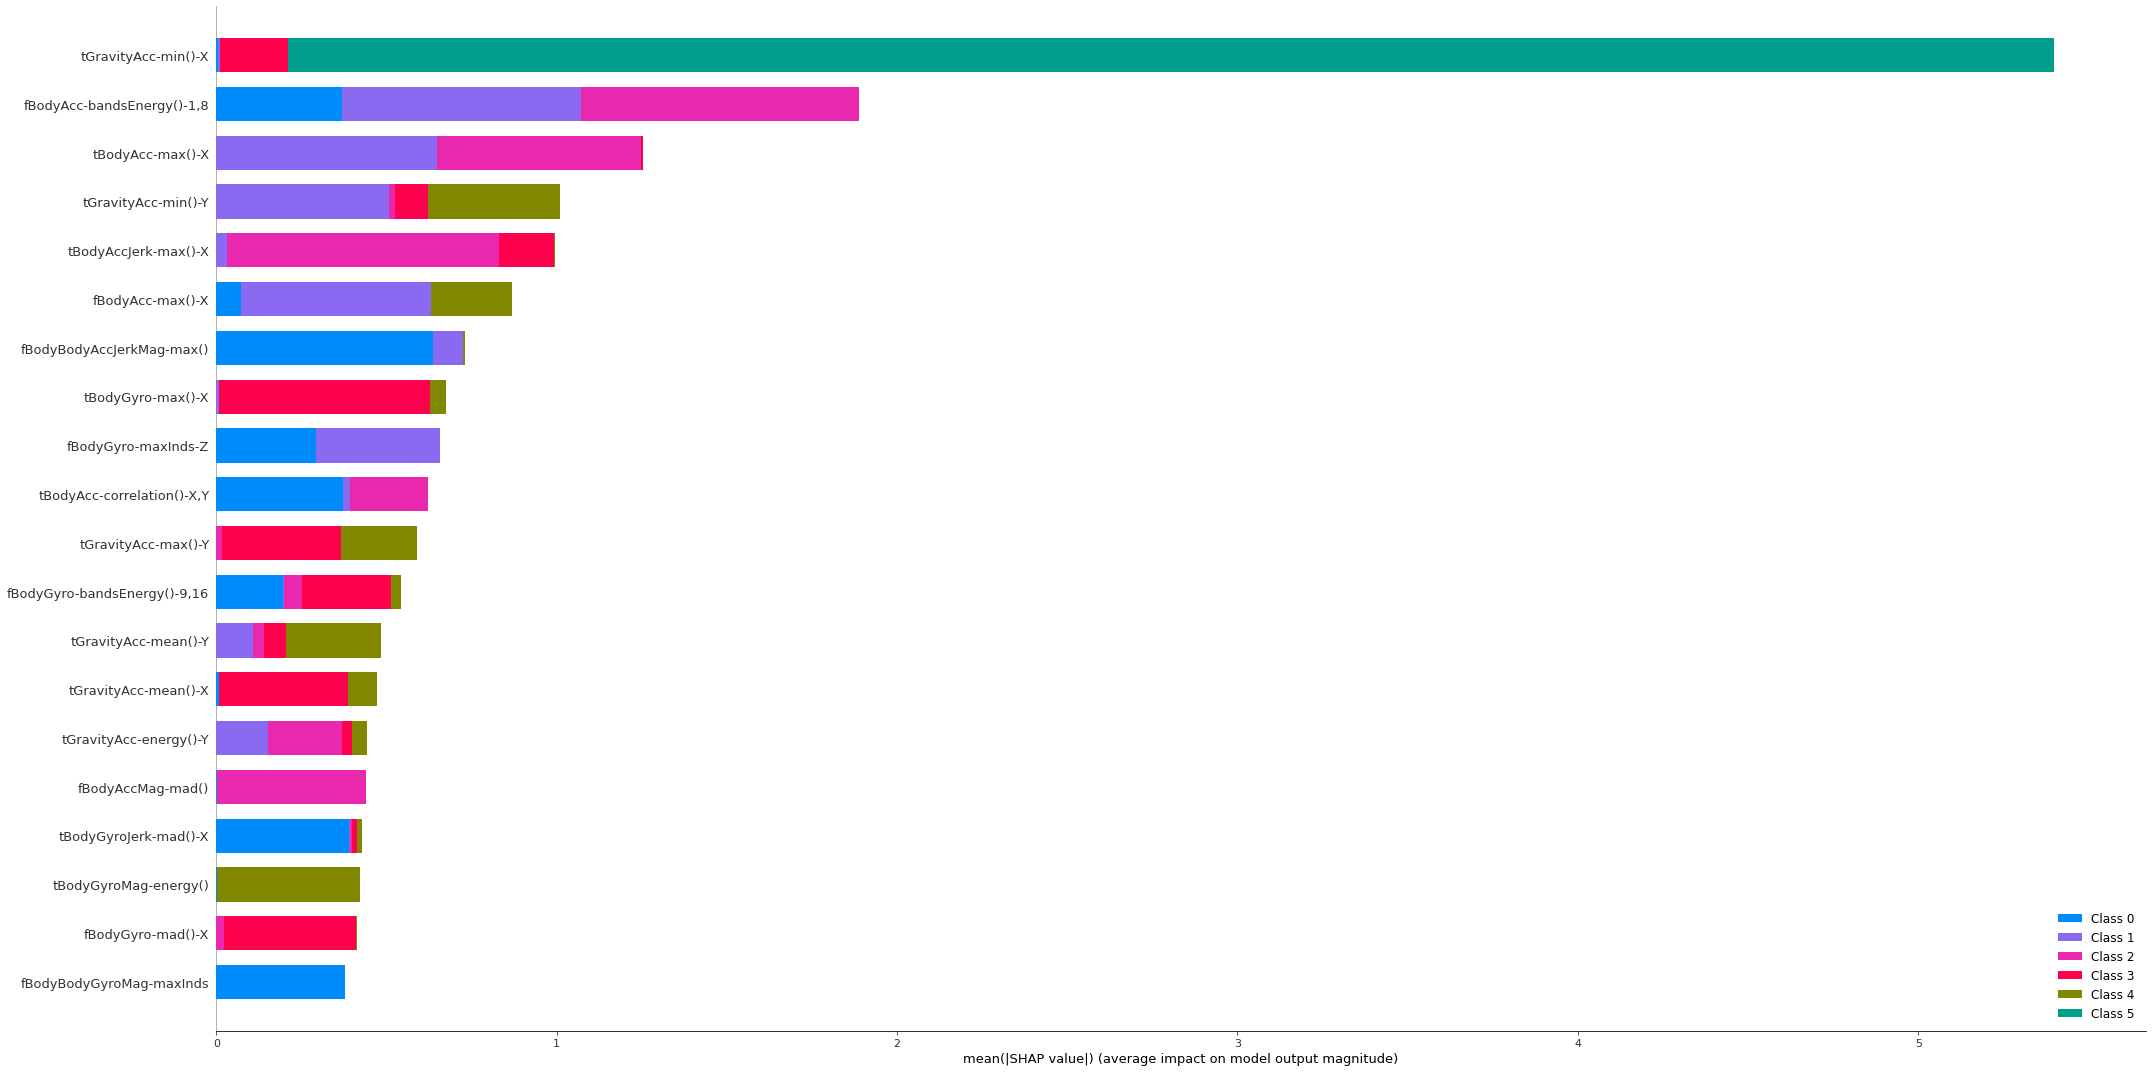

In [56]:
shap.summary_plot(shap_values, #Use Shap values array
                  features=XFull, # Use training set features
                  feature_names=features, #Use column names
                  show=False, #Set to false to output to folder
                  plot_size=(30,15)) # Change plot size